In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import algorithms, base, creator, tools

## Loading data

In [11]:
returns = pd.read_csv("../data/weekly_returns.csv",index_col="Date")
ibov = pd.read_csv("../data/weekly_ibov.csv",index_col="Date")
volatilities = pd.read_csv("../data/volatility_garch_1_1_7.csv",index_col="Date")

returns.index = pd.to_datetime(returns.index)
ibov.index = pd.to_datetime(ibov.index)
volatilities.index = pd.to_datetime(volatilities.index)

The function below is responsible for getting the portifolio return based on each asset return and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_returns: array with each element being the asset return. 

*Disclaimer:*
 - Each asset expected return may be obtained with different techniques. In this first version, the expected return is simply the last observed return. In other words, $\hat{y}_t=y_{t-1}$ 
 - Asset returns were obtained with the log-return of the asset Adjusted Closed Price.

In [23]:
def portifolio_return(weights, asset_returns):
    
    '''
    First version -> the expected return from each asset is exactly the last return, which is inspired on Random Walk
    Weights will be othe GA individual
    '''
    
    port_ret = np.dot(weights,asset_returns)
    
    return port_ret

The function below is responsible for getting the portifolio volatility based on each asset volatility and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_volatilities: array with each element being the asset volatility predicted by a GARCH Model. 

*Disclaimer:*
 - In the current version, volatilities are being estimated through historical variance and covariance

In [45]:
def portifolio_volatility_naive(weights, returns):
    
    cov_matrix = returns.cov()
    weights_np = np.array(weights)
    
    port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
    
    return port_vol

In [25]:
weights = np.ones(len(returns.iloc[0,:]))/len(returns.iloc[0,:])


portifolio_return(asset_returns=returns.iloc[0,:],
                  weights=weights)



0.023543951421836032

## GA Optimization

In [54]:
#First, only maximize portfolio return
def objective_function(individual):

    return portifolio_return(individual,asset_returns)    
    

In [79]:
def feasible(individual):
    cond1 = 1-sum(individual)>0 
    cond2 = 1-sum(individual)<10e-7
    
    all_positive = True
    for gene in individual:
        if gene < 0:
            all_positive = False
    return cond1 and cond2 and all_positive 

In [73]:
def distance(individual):
    
    return abs(sum(individual)-1)

### GA setup

In [74]:
creator.create('FitnessMax',base.Fitness,weights=(1.0,)) 
creator.create('Individual',list,fitness=creator.FitnessMax) 

In [77]:
toolbox = base.Toolbox()

toolbox.register("attr_weight", random.uniform, 0, 1/19)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_weight, n=19)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  

In [78]:
toolbox.register("evaluate", objective_function)     
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0, distance))

In [80]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [81]:
pop = toolbox.population(n=100) 
hof = tools.HallOfFame(1) #melhores indiviudos a cada rodada
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('avg',np.mean)
stats.register('std',np.std)
stats.register('max',np.max)
stats.register('min',np.min)

In [91]:
best_individuals = {}
optimal_returns = {}
for idx,row in returns.iterrows():
    asset_returns = row
    pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=0.5, mutpb=0.1,
                              ngen=50, stats=stats, halloffame=hof,verbose=False)
    

    best_individuals[idx] = hof[0]
    optimal_returns[idx] = objective_function(hof[0])

    

In [98]:
optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())

optimal_returns.rename(columns={0:"Return"},inplace=True)
optimal_returns

,Return
2010-01-04,0.023516
2010-01-11,-0.016185
2010-01-18,-0.026214
2010-01-25,0.005613
2010-02-01,-0.045550
...,...
2021-11-29,0.026524
2021-12-06,0.022138
2021-12-13,-0.007821
2021-12-20,-0.021257


In [99]:
portifolio_cummulative_return = optimal_returns.cumsum()

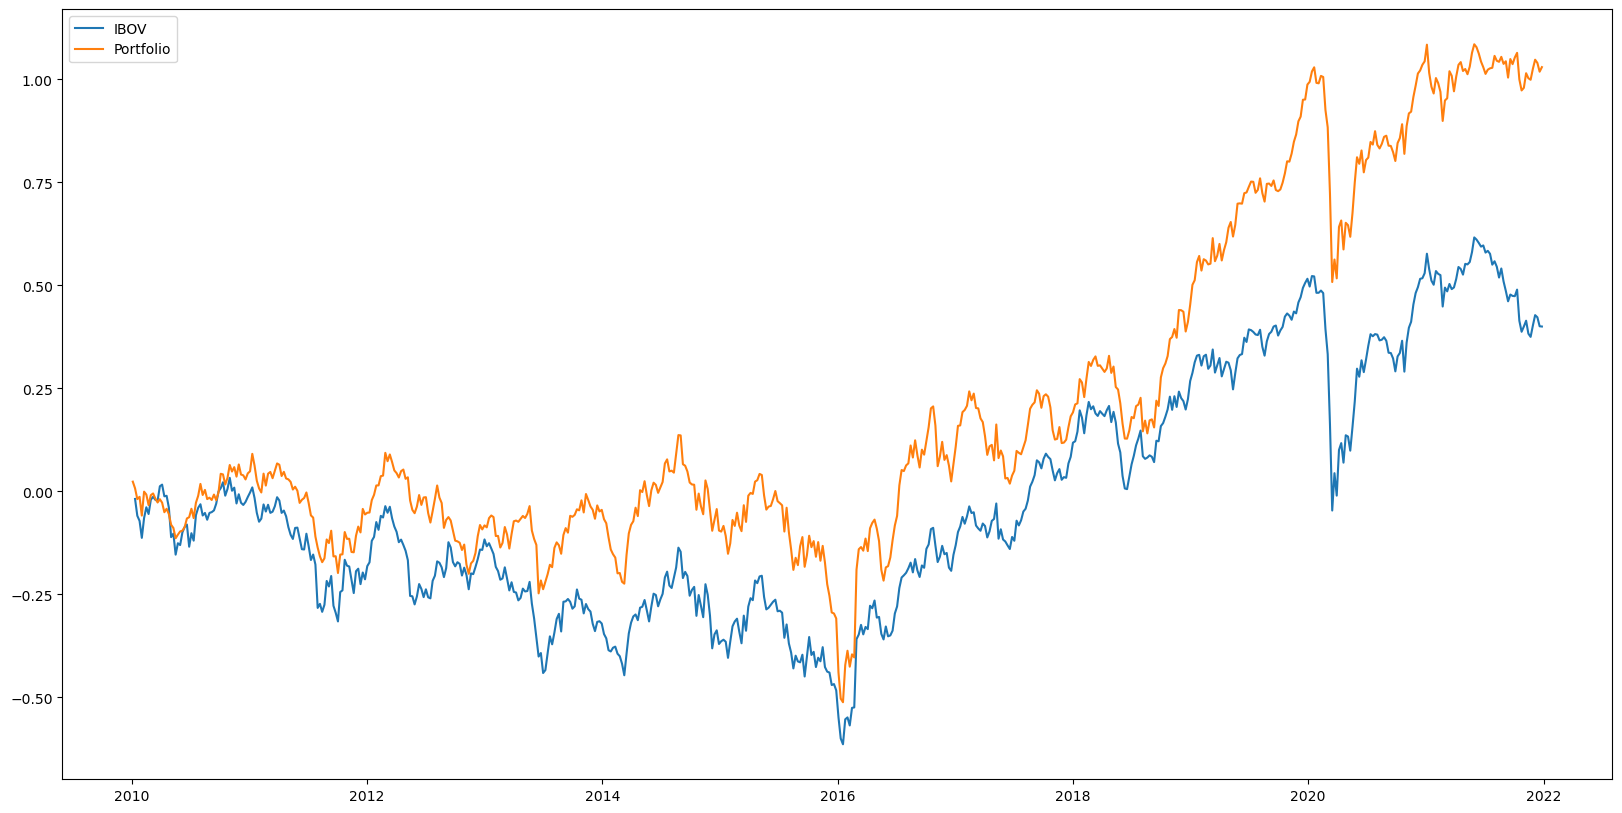

In [100]:
ibov_cummulative_return = ibov.cumsum()

plt.figure(figsize=(20,10))
plt.plot(ibov_cummulative_return,label="IBOV")
plt.plot(portifolio_cummulative_return,label="Portfolio")
plt.legend()
plt.show()